<a href="https://www.kaggle.com/code/manoharreddyvoladri/ml-project-mangifera-indica-pathology-detector?scriptVersionId=175293419" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import add,Dense
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_hub as hub
import os, random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# importing our dependeses and importing the data

In [2]:
tf.random.set_seed(42)

In [3]:
train = image_dataset_from_directory(
    '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset',  
    seed=42,
    validation_split=0.2,
    subset='training',
    image_size=(256,256),
)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.


In [4]:
val =image_dataset_from_directory(
    '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset',  
    seed=42,
    validation_split=0.2,
    subset='validation',
    image_size=(256,256),
)

Found 4000 files belonging to 8 classes.
Using 800 files for validation.


# building the model and fitting it

In [5]:
model = Sequential([
    layers.Conv2D(256,5,input_shape=(256,256,3),activation="relu"),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    
    layers.Conv2D(128,3,activation="relu"),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    
    layers.Conv2D(64,3,activation="relu"),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    
    layers.Conv2D(32,3,activation="relu"),
    layers.MaxPool2D(),
    layers.BatchNormalization(),

    layers.Conv2D(16,3,activation="relu"),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(8,activation="softmax")
])


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 256)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 126, 126, 256)     1024      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                        

In [7]:
earlystopping=tf.keras.callbacks.EarlyStopping(
    monitor='Accuracy',
    min_delta=0.0001,
    patience=2,
    restore_best_weights=True,
    start_from_epoch=10
)

tensorboard= tf.keras.callbacks.TensorBoard()
chkpt = tf.keras.callbacks.ModelCheckpoint(
    'mango.ckpt',
    monitor = 'Accuracy',
    save_best_only = True,
    mode = 'auto',
    save_freq='epoch',
)

In [8]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['Accuracy']
)

In [9]:
with tf.device('/GPU:0'):
    model.fit(train, #specifing the training data
              validation_data= val, #specifing the validation data
              epochs=1, #the amount of epochs is the amount of repetions in this case 20
              callbacks=[earlystopping,tensorboard,chkpt]) #this is saying that the model must do the callbacks

100/100 [==============================] - 29s 198ms/step - loss: 0.9453 - Accuracy: 0.6603 - val_loss: 15.8773 - val_Accuracy: 0.3325


# saving and testing the model

In [10]:
model.save('saved_model/my_model')

In [11]:
loaded_model = tf.keras.models.load_model('saved_model/my_model')
# Check its architecture
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 256)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 126, 126, 256)     1024      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                        

In [12]:
class_names=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [13]:
w = random.choice(os.listdir("/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset")) 
m = str('/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/'+w)
n =random.choice(os.listdir(m))

In [14]:
im2=cv.imread(str(m+"/"+n))
im2=cv.resize(im2, (256,256)) # resize to 256 as that is on which model is trained on
print(im2.shape)
img2 = tf.expand_dims(im2, 0) # expand the dims means change shape from (256,256, 3) to (1, 256,256, 3)
print(img2.shape)

predictions = loaded_model.predict(img2)
score = tf.nn.softmax(predictions[0]) # # get softmax for each output

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
print('while the correct answer was {}'.format(w))

(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 0s 334ms/step
This image most likely belongs to Healthy with a 26.38 percent confidence.
while the correct answer was Die Back


In [15]:
model.save_weights('my_model_weights.h5')

1/1 [==============================] - 0s 126ms/step


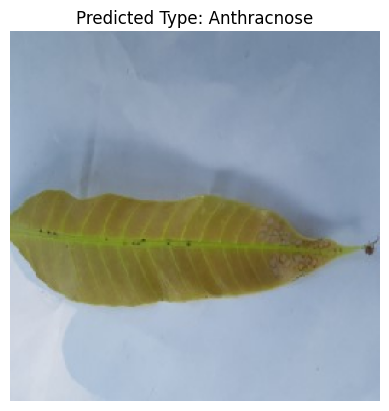

In [16]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):
    
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Type: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('/kaggle/working/my_model_weights.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = class_names

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Anthracnose/20211008_124253 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)


1/1 [==============================] - 0s 21ms/step


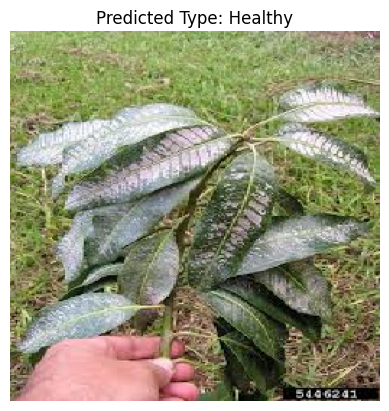

In [18]:
image_path_to_test = '/kaggle/input/testing-purpose/group.jpeg'
predict_and_display(image_path_to_test, model, class_labels)
